In [1]:
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps
from locscale.preprocessing.headers import run_servalcat_iterative
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map
import os
import numpy as np


In [2]:
refmac_iterations = np.arange(1, 30, dtype=int)
def copy_files_to_folder(file, folder):
    import shutil
    copied_file_path = shutil.copy(file, folder)
    return copied_file_path
    
parent_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis"
model_path = [os.path.join(parent_folder, x) for x in os.listdir(parent_folder) if x.endswith('.cif')][0]
halfmap1_path = [os.path.join(parent_folder, x) for x in os.listdir(parent_folder) if "half_map_1" in x ][0]
halfmap2_path = [os.path.join(parent_folder, x) for x in os.listdir(parent_folder) if "half_map_2" in x ][0]
mask_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/emd_8702_FDR_confidence_final.map"
num_iter = 30
resolution = 2.6

emmap,apix = load_map(halfmap1_path)

input_folder = os.path.dirname(model_path)
output_folder = os.path.join(input_folder, 'refmac_iteration_analysis_output_{}'.format(num_iter))

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

model_map_output_folder = os.path.join(output_folder, 'model_maps')
if not os.path.exists(model_map_output_folder):
    os.makedirs(model_map_output_folder)
    
copied_map_path = copy_files_to_folder(halfmap1_path, output_folder)
copied_map2_path = copy_files_to_folder(halfmap2_path, output_folder)
copied_model_path = copy_files_to_folder(model_path, output_folder)

# refined_model_path = run_servalcat_iterative(
#     model_path=copied_model_path, map_path=copied_map_path, pseudomodel_refinement=True,
#                 resolution=resolution, num_iter=num_iter)

refined_model_per_iteration = {k : os.path.join(parent_folder, "refmac_iteration_50",f"servalcat_refinement_cycle_{k}_servalcat_refined.pdb") for k in refmac_iterations}



In [3]:
from locscale.include.emmer.ndimage.map_utils import load_map
from locscale.emmernet.emmernet_functions import load_smoothened_mask

def compute_fsc_cycle(cycle, halfmap1_path, halfmap2_path,refined_model_map_path, mask_path):
    #refined_model_cycle = refined_modelmap_per_iteration[cycle]

    assert os.path.exists(refined_model_map_path), f"Refined model map path {refined_model_map_path} does not exist"
    assert os.path.exists(halfmap1_path), f"Halfmap1 path {halfmap1_path} does not exist"
    assert os.path.exists(halfmap2_path), f"Halfmap2 path {halfmap2_path} does not exist"
    
    softmask, apix = load_smoothened_mask(mask_path)
    halfmap1, apix = load_map(halfmap1_path)
    halfmap2, apix = load_map(halfmap2_path)
    refined_model_map, apix = load_map(refined_model_map_path)
    
    #fsc_vals_halfmap1 = calculate_fsc_maps(refined_model_map_path, halfmap1_path)
    #fsc_vals_halfmap2 = calculate_fsc_maps(refined_model_map_path, halfmap2_path)
    fsc_vals_halfmap1 = calculate_fsc_maps(refined_model_map * softmask, halfmap1 * softmask)
    fsc_vals_halfmap2 = calculate_fsc_maps(refined_model_map * softmask, halfmap2 * softmask)
    

    fsc_average_halfmap1 = (cycle, np.mean(fsc_vals_halfmap1), fsc_vals_halfmap1)
    fsc_average_halfmap2 = (cycle, np.mean(fsc_vals_halfmap2), fsc_vals_halfmap2)

    results = { 
        "cycle" : cycle,
        "halfmap1" : fsc_average_halfmap1,
        "halfmap2" : fsc_average_halfmap2
    }
    return results

def create_model_map_path(cycle):
    pdb_path = refined_model_per_iteration[cycle]
    simmap = pdb2map(pdb_path, size=emmap.shape, apix=apix)
    save_as_mrc(simmap, os.path.join(model_map_output_folder, f"model_map_cycle_{cycle}.mrc"), apix=apix)
    

In [4]:
import joblib
# Run the computation in parallel for all the cycles (for the case: without averaging)
n_jobs = 15
verbose = 10

# # Create the model map for each cycle
# joblib.Parallel(n_jobs=n_jobs, verbose=verbose)(
#     joblib.delayed(create_model_map_path)(cycle) for cycle in refmac_iterations
# )


In [5]:

# Run the computation in parallel for all the cycles (for the case: with averaging)
model_map_paths_with_averaging = {k : os.path.join(model_map_output_folder, f"model_map_cycle_{k}.mrc") for k in refmac_iterations}
results_with_averaging = joblib.Parallel(n_jobs=n_jobs, verbose=10)(
            joblib.delayed(compute_fsc_cycle)(cycle, halfmap1_path, halfmap2_path, model_map_paths_with_averaging[cycle], mask_path)\
                                                        for cycle in refmac_iterations)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  29 | elapsed:  1.9min remaining: 16.8min
[Parallel(n_jobs=15)]: Done   6 out of  29 | elapsed:  2.0min remaining:  7.5min
[Parallel(n_jobs=15)]: Done   9 out of  29 | elapsed:  2.0min remaining:  4.4min
[Parallel(n_jobs=15)]: Done  12 out of  29 | elapsed:  2.0min remaining:  2.8min
[Parallel(n_jobs=15)]: Done  15 out of  29 | elapsed:  2.0min remaining:  1.9min
[Parallel(n_jobs=15)]: Done  18 out of  29 | elapsed:  3.7min remaining:  2.3min
[Parallel(n_jobs=15)]: Done  21 out of  29 | elapsed:  3.7min remaining:  1.4min
[Parallel(n_jobs=15)]: Done  24 out of  29 | elapsed:  3.8min remaining:   47.0s
[Parallel(n_jobs=15)]: Done  27 out of  29 | elapsed:  3.8min remaining:   16.8s
[Parallel(n_jobs=15)]: Done  29 out of  29 | elapsed:  3.8min finished


In [6]:

fsc_cycles_halfmap1_with_averaging = {}
fsc_cycles_halfmap2_with_averaging = {}
for result in results_with_averaging:
    cycle = result["cycle"]
    fsc_cycles_halfmap1_with_averaging[cycle] = result["halfmap1"]
    fsc_cycles_halfmap2_with_averaging[cycle] = result["halfmap2"]
    
# Dump the fsc values to a file in the input folder
# import pickle
# with open(os.path.join(output_folder, f'fsc_average_halfmap_2_cycle{num_iter}_masked.pickle'), 'wb') as f:
#     pickle.dump(fsc_cycles_halfmap2_with_averaging, f)
# with open(os.path.join(output_folder, f'fsc_average_halfmap_1_cycle{num_iter}_masked.pickle'), 'wb') as f:
#     pickle.dump(fsc_cycles_halfmap1_with_averaging, f)



    

In [7]:

def pretty_plot_fsc_curve(freq,list_of_profiles_native,  \
                                legends=None,figsize_cm=(14,8), fontsize=10,linewidth=1, \
                                marker="o", markersize=5,font="Helvetica",fontscale=1, showlegend=True, showPoints=False, \
                                alpha=1, variation=None, yticks=None, ylims=None, xlims=None, crop_freq=None, labelsize=None, title=None):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    from locscale.include.emmer.ndimage.profile_tools import crop_profile_between_frequency
    import seaborn as sns
    import matplotlib 
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    # set the global font size for the plot

        
    plt.rcParams.update({'font.size': fontsize})
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54) # convert cm to inches
    
    fig, ax1 = plt.subplots(figsize=figsize, dpi=600)  # DPI is fixed to 600 for publication quality
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    # Set font size for all text in the figure
    sns.set_style("white")

    
    
    # Crop frequencies if required
    if crop_freq is not None:
        cropped_frequency = crop_profile_between_frequency(freq, list_of_profiles_native[0], crop_freq[0], crop_freq[1])[0]
        cropped_profiles = [crop_profile_between_frequency(freq, profile, crop_freq[0], crop_freq[1])[1] for profile in list_of_profiles_native]
    else:
        cropped_frequency = freq
        cropped_profiles = list_of_profiles_native
    
    final_list_of_profiles = cropped_profiles
    plot_frequency_axis = cropped_frequency
    
    # Add labels to the plot
    xlabel_top = r'Resolution, $d (\AA)$'

    xlabel = r'Spatial Frequency, $d^{-1} (\AA^{-1})$'
    ylabel = r'FSC'
    
    colors = cm.rainbow(np.linspace(0,1,len(final_list_of_profiles)))
    
    ax1.grid(False)
    ax2 = ax1.twiny()

    for i, profile in enumerate(final_list_of_profiles):
        if showPoints:
            ax1.plot(plot_frequency_axis, profile, marker=marker, markersize=markersize, color=colors[i], alpha=alpha, \
                        linewidth=linewidth, label=legends[i])
        else:
            ax1.plot(plot_frequency_axis, profile, color=colors[i], alpha=alpha, linewidth=linewidth, label=legends[i])
                
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels([round(1/x,1) for x in ax1.get_xticks()])
    #ax2.tick_params(axis="both", which="both", labelsize=labelsize)

    if showlegend:
        ax1.legend(loc="best")
    ax1.set_xlabel(xlabel)#, fontsize=fontsize)
    ax1.set_ylabel(ylabel)#, fontsize=fontsize)
    #ax1.tick_params(axis="both", which="both", labelsize=labelsize)
    ax2.set_xlabel(xlabel_top)#, fontsize=fontsize)
    
    if ylims is not None:
        plt.ylim(ylims)
    if yticks is not None:
        plt.yticks(yticks)
    if xlims is not None:
        plt.xlim(xlims)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig



In [8]:
## Figure 2_ add FSC curves at cycle 1, 5 and 10 to the figure where FSC is calculated between the refined model and the halfmap 2 and halfmap 1
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map
from locscale.include.emmer.ndimage.profile_tools import frequency_array
import os
import numpy as np
import matplotlib.pyplot as plt


refined_model_map_cycle_1_path = os.path.join(model_map_output_folder, f"model_map_cycle_1.mrc")
refined_model_map_cycle_5_path = os.path.join(model_map_output_folder, f"model_map_cycle_5.mrc")
refined_model_map_cycle_10_path = os.path.join(model_map_output_folder, f"model_map_cycle_10.mrc")
refined_model_map_cycle_20_path = os.path.join(model_map_output_folder, f"model_map_cycle_20.mrc")
halfmap2_path = copied_map2_path
halfmap1_path = copied_map_path

# fsc_cycle_1_halfmap1 = calculate_fsc_maps(refined_model_map_cycle_1_path, halfmap1_path)
# fsc_cycle_1_halfmap2 = calculate_fsc_maps(refined_model_map_cycle_1_path, halfmap2_path)

# fsc_cycle_5_halfmap1 = calculate_fsc_maps(refined_model_map_cycle_5_path, halfmap1_path)
# fsc_cycle_5_halfmap2 = calculate_fsc_maps(refined_model_map_cycle_5_path, halfmap2_path)

# fsc_cycle_10_halfmap1 = calculate_fsc_maps(refined_model_map_cycle_10_path, halfmap1_path)
# fsc_cycle_10_halfmap2 = calculate_fsc_maps(refined_model_map_cycle_10_path, halfmap2_path)

# fsc_cycle_20_halfmap1 = calculate_fsc_maps(refined_model_map_cycle_20_path, halfmap1_path)
# fsc_cycle_20_halfmap2 = calculate_fsc_maps(refined_model_map_cycle_20_path, halfmap2_path)

fsc_cycle_1_halfmap1 = fsc_cycles_halfmap1_with_averaging[1][2]
fsc_cycle_1_halfmap2 = fsc_cycles_halfmap2_with_averaging[1][2]

fsc_cycle_5_halfmap1 = fsc_cycles_halfmap1_with_averaging[5][2]
fsc_cycle_5_halfmap2 = fsc_cycles_halfmap2_with_averaging[5][2]

fsc_cycle_10_halfmap1 = fsc_cycles_halfmap1_with_averaging[10][2]
fsc_cycle_10_halfmap2 = fsc_cycles_halfmap2_with_averaging[10][2]

fsc_cycle_20_halfmap1 = fsc_cycles_halfmap1_with_averaging[20][2]
fsc_cycle_20_halfmap2 = fsc_cycles_halfmap2_with_averaging[20][2]


_, apix = load_map(halfmap1_path)

list_of_cycle_1_fsc = [fsc_cycle_1_halfmap1, fsc_cycle_1_halfmap2]
list_of_cycle_5_fsc = [fsc_cycle_5_halfmap1, fsc_cycle_5_halfmap2]
list_of_cycle_10_fsc = [fsc_cycle_10_halfmap1, fsc_cycle_10_halfmap2]
list_of_cycle_20_fsc = [fsc_cycle_20_halfmap1, fsc_cycle_20_halfmap2]
freq = frequency_array(fsc_cycle_1_halfmap1, apix)




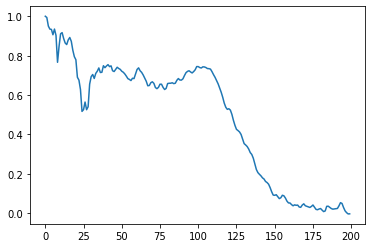

In [9]:
plt.plot(fsc_cycle_1_halfmap1)

In [10]:
def find_freq_value_where_fsc_drops_below_threshold(freq, *fsc_curves, threshold=0.5):
    from scipy.interpolate import interp1d
    freq_values = []
    for fsc_curve in fsc_curves:
        xarray = np.array(fsc_curve)
        yarray = np.array(freq)
        g = interp1d(xarray, yarray)
        freq_values.append(g(threshold))
    return freq_values


/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


(-0.05, 1.0)

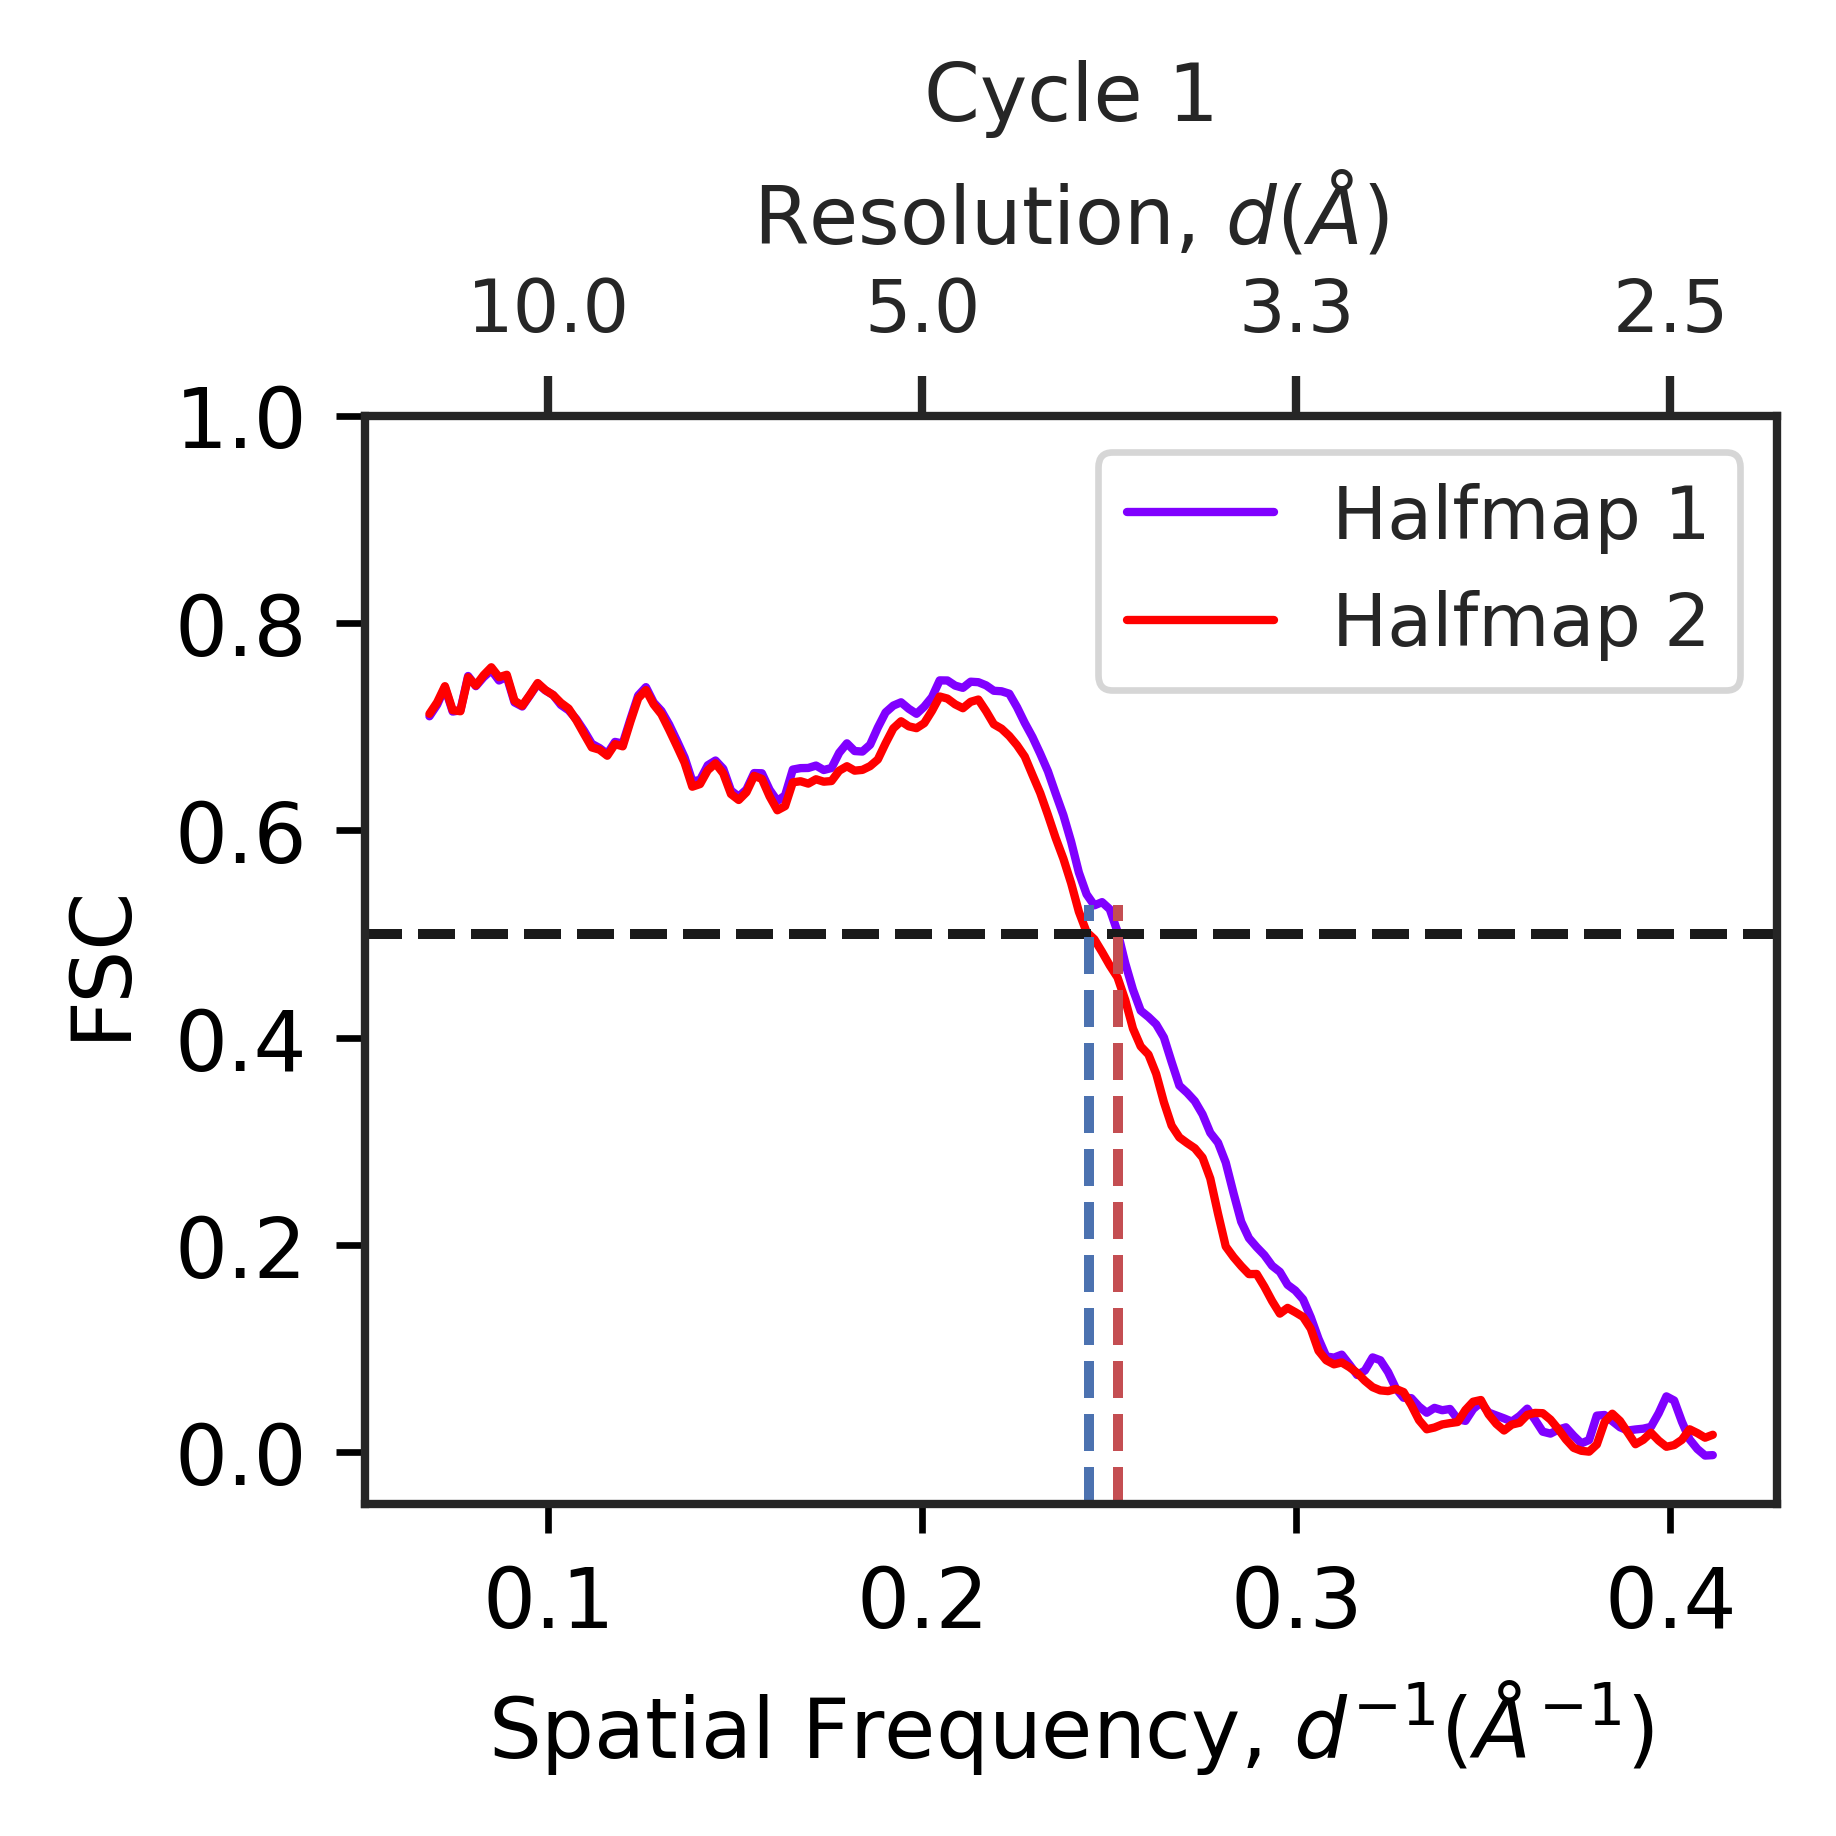

In [11]:
ylims = (-0.05,1)
fig_cycle_1 = pretty_plot_fsc_curve(freq, list_of_cycle_1_fsc, legends=["Halfmap 1", "Halfmap 2"], \
                                    showPoints=False, showlegend=True, title="Cycle 1", figsize_cm=(8,8), crop_freq=(15,1.8), ylims=ylims)
# add a horizontal line at 0.5 and draw a vertical line at the intersection of the FSC curve with the horizontal line
freq_1, freq_2 = find_freq_value_where_fsc_drops_below_threshold(freq, fsc_cycle_1_halfmap1, fsc_cycle_1_halfmap2, threshold=0.5)
freq_max = max(freq_1, freq_2)
fig_cycle_1.axes[0].axhline(y=0.5, color='k', linestyle='--')
fig_cycle_1.axes[0].axvline(x=freq_1, color='r', linestyle='--', ymax=0.55)
fig_cycle_1.axes[0].axvline(x=freq_2, color='b', linestyle='--', ymax=0.55)

fig_cycle_1.axes[0].set_ylim(ylims)

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


(-0.05, 1.0)

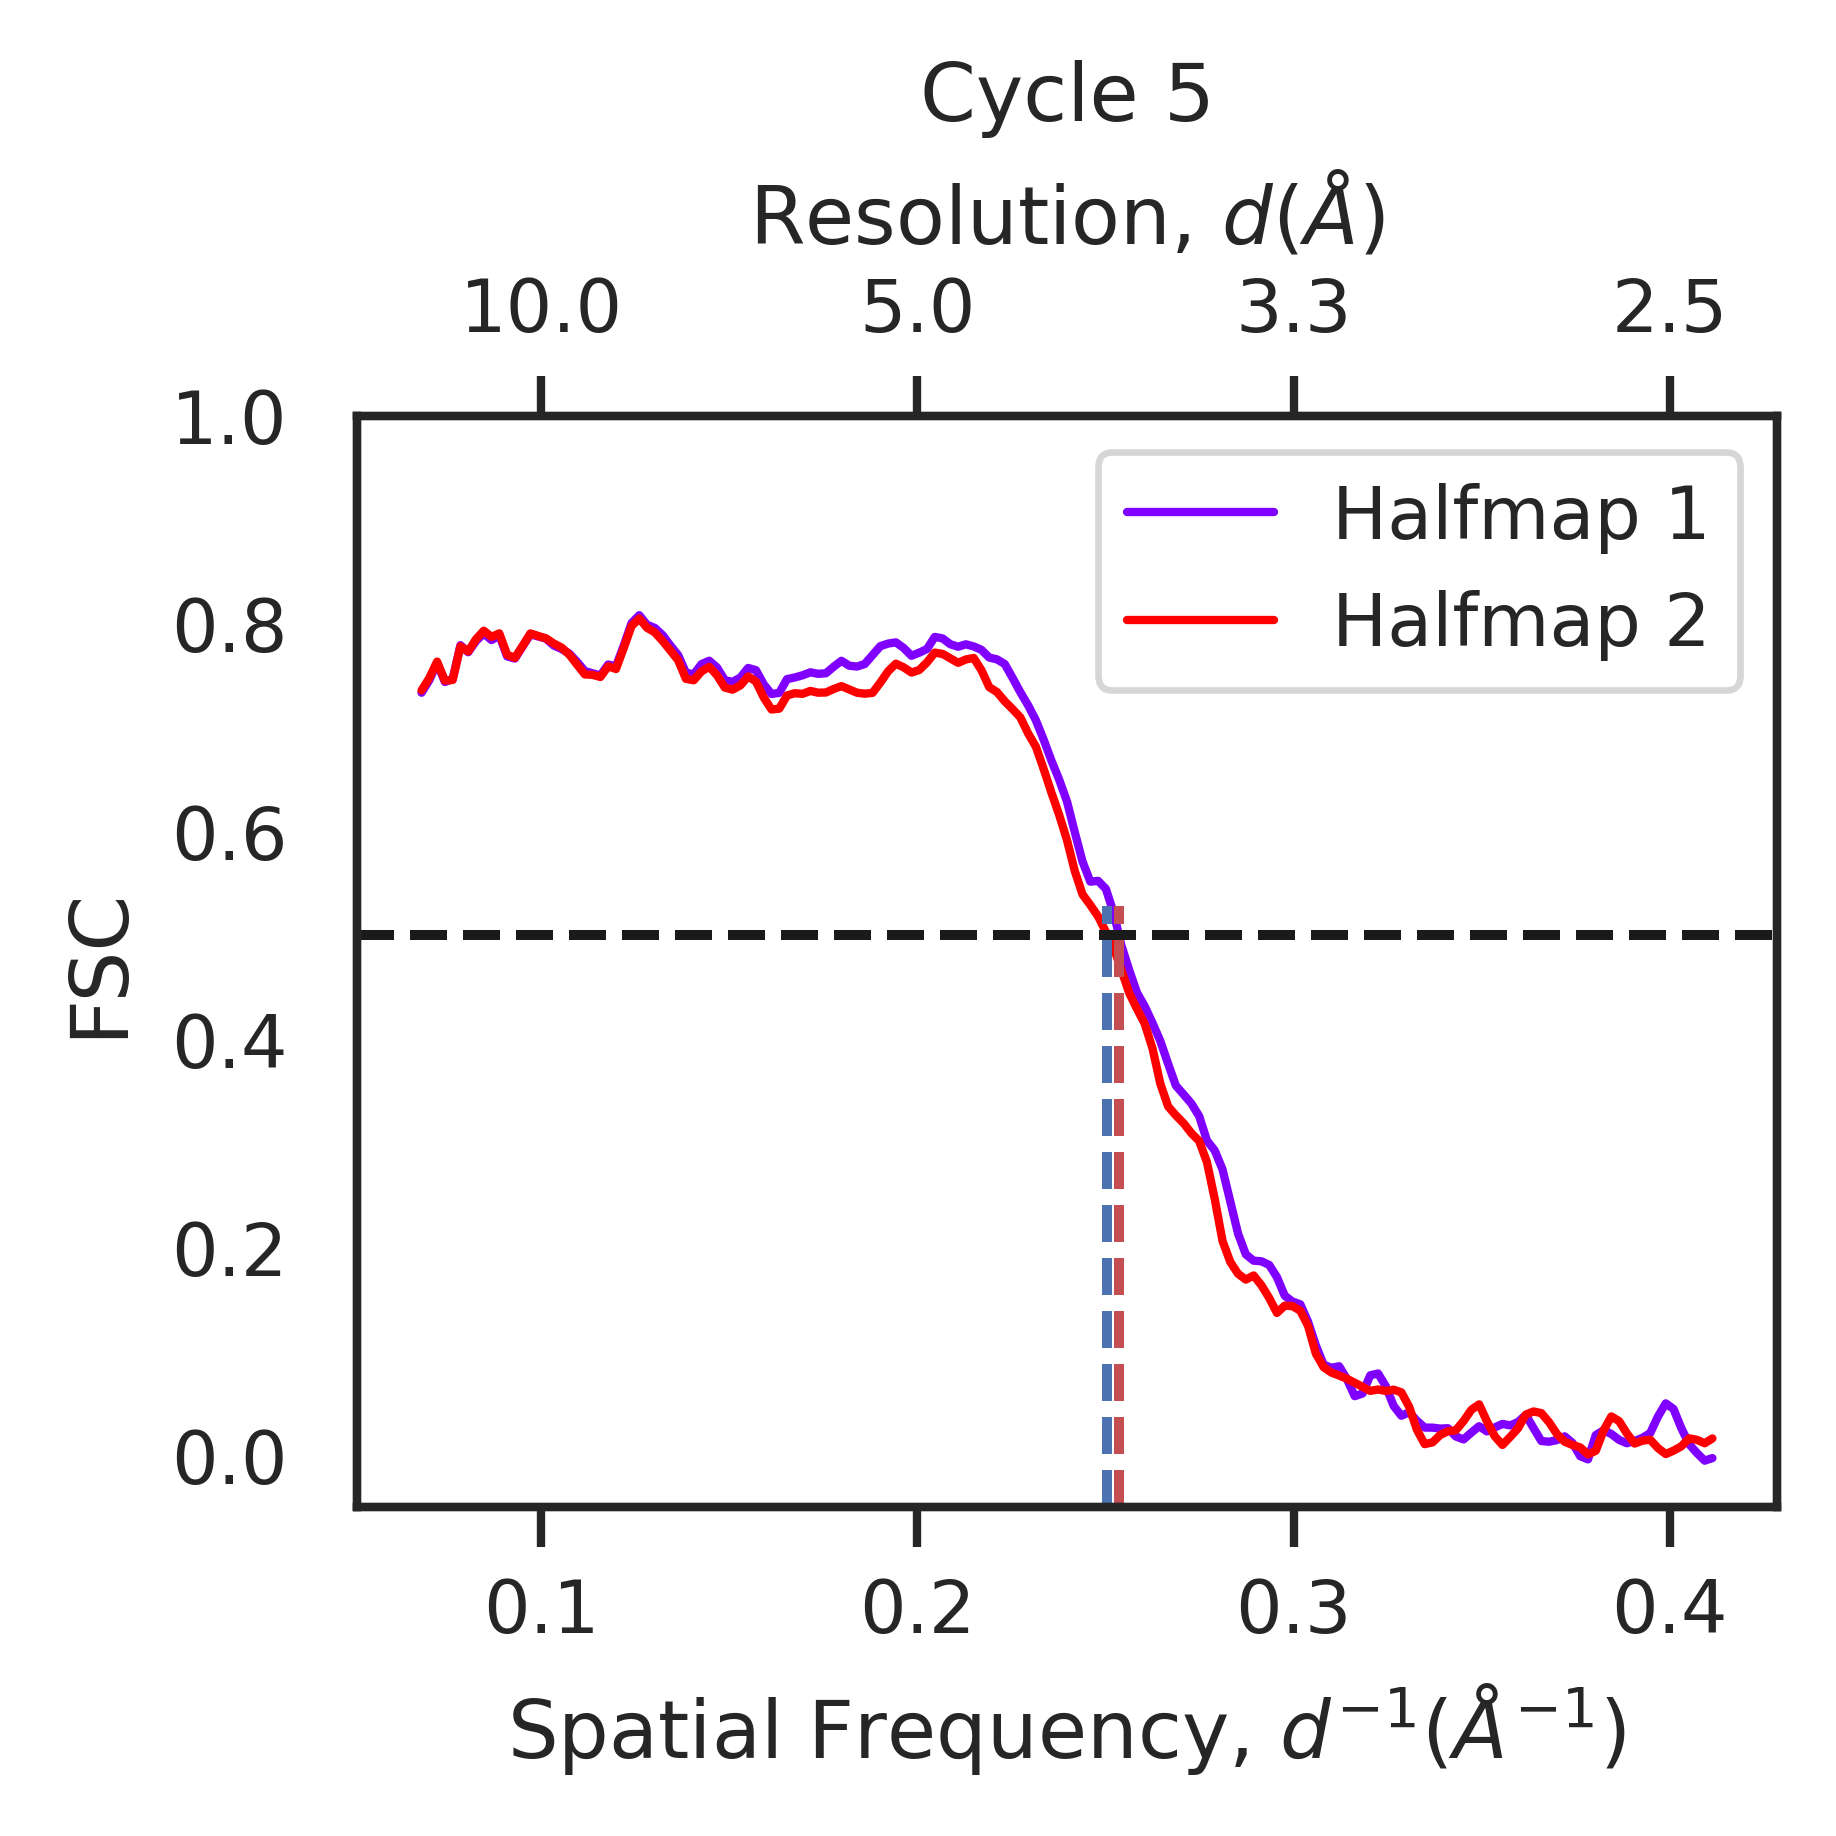

In [12]:
fig_cycle_5 = pretty_plot_fsc_curve(freq, list_of_cycle_5_fsc, legends=["Halfmap 1", "Halfmap 2"], \
                                    showPoints=False, showlegend=True, title="Cycle 5", figsize_cm=(8,8), crop_freq=(15,1.8), ylims=ylims)

# add a horizontal line at 0.5 and draw a vertical line at the intersection of the FSC curve with the horizontal line


freq_1, freq_2 = find_freq_value_where_fsc_drops_below_threshold(freq, *list_of_cycle_5_fsc, threshold=0.5)
freq_max = max(freq_1, freq_2)
fig_cycle_5.axes[0].axhline(y=0.5, color='k', linestyle='--')
fig_cycle_5.axes[0].axvline(x=freq_1, color='r', linestyle='--', ymax=0.55)
fig_cycle_5.axes[0].axvline(x=freq_2, color='b', linestyle='--', ymax=0.55)

fig_cycle_5.axes[0].set_ylim(ylims)

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


(-0.05, 1.0)

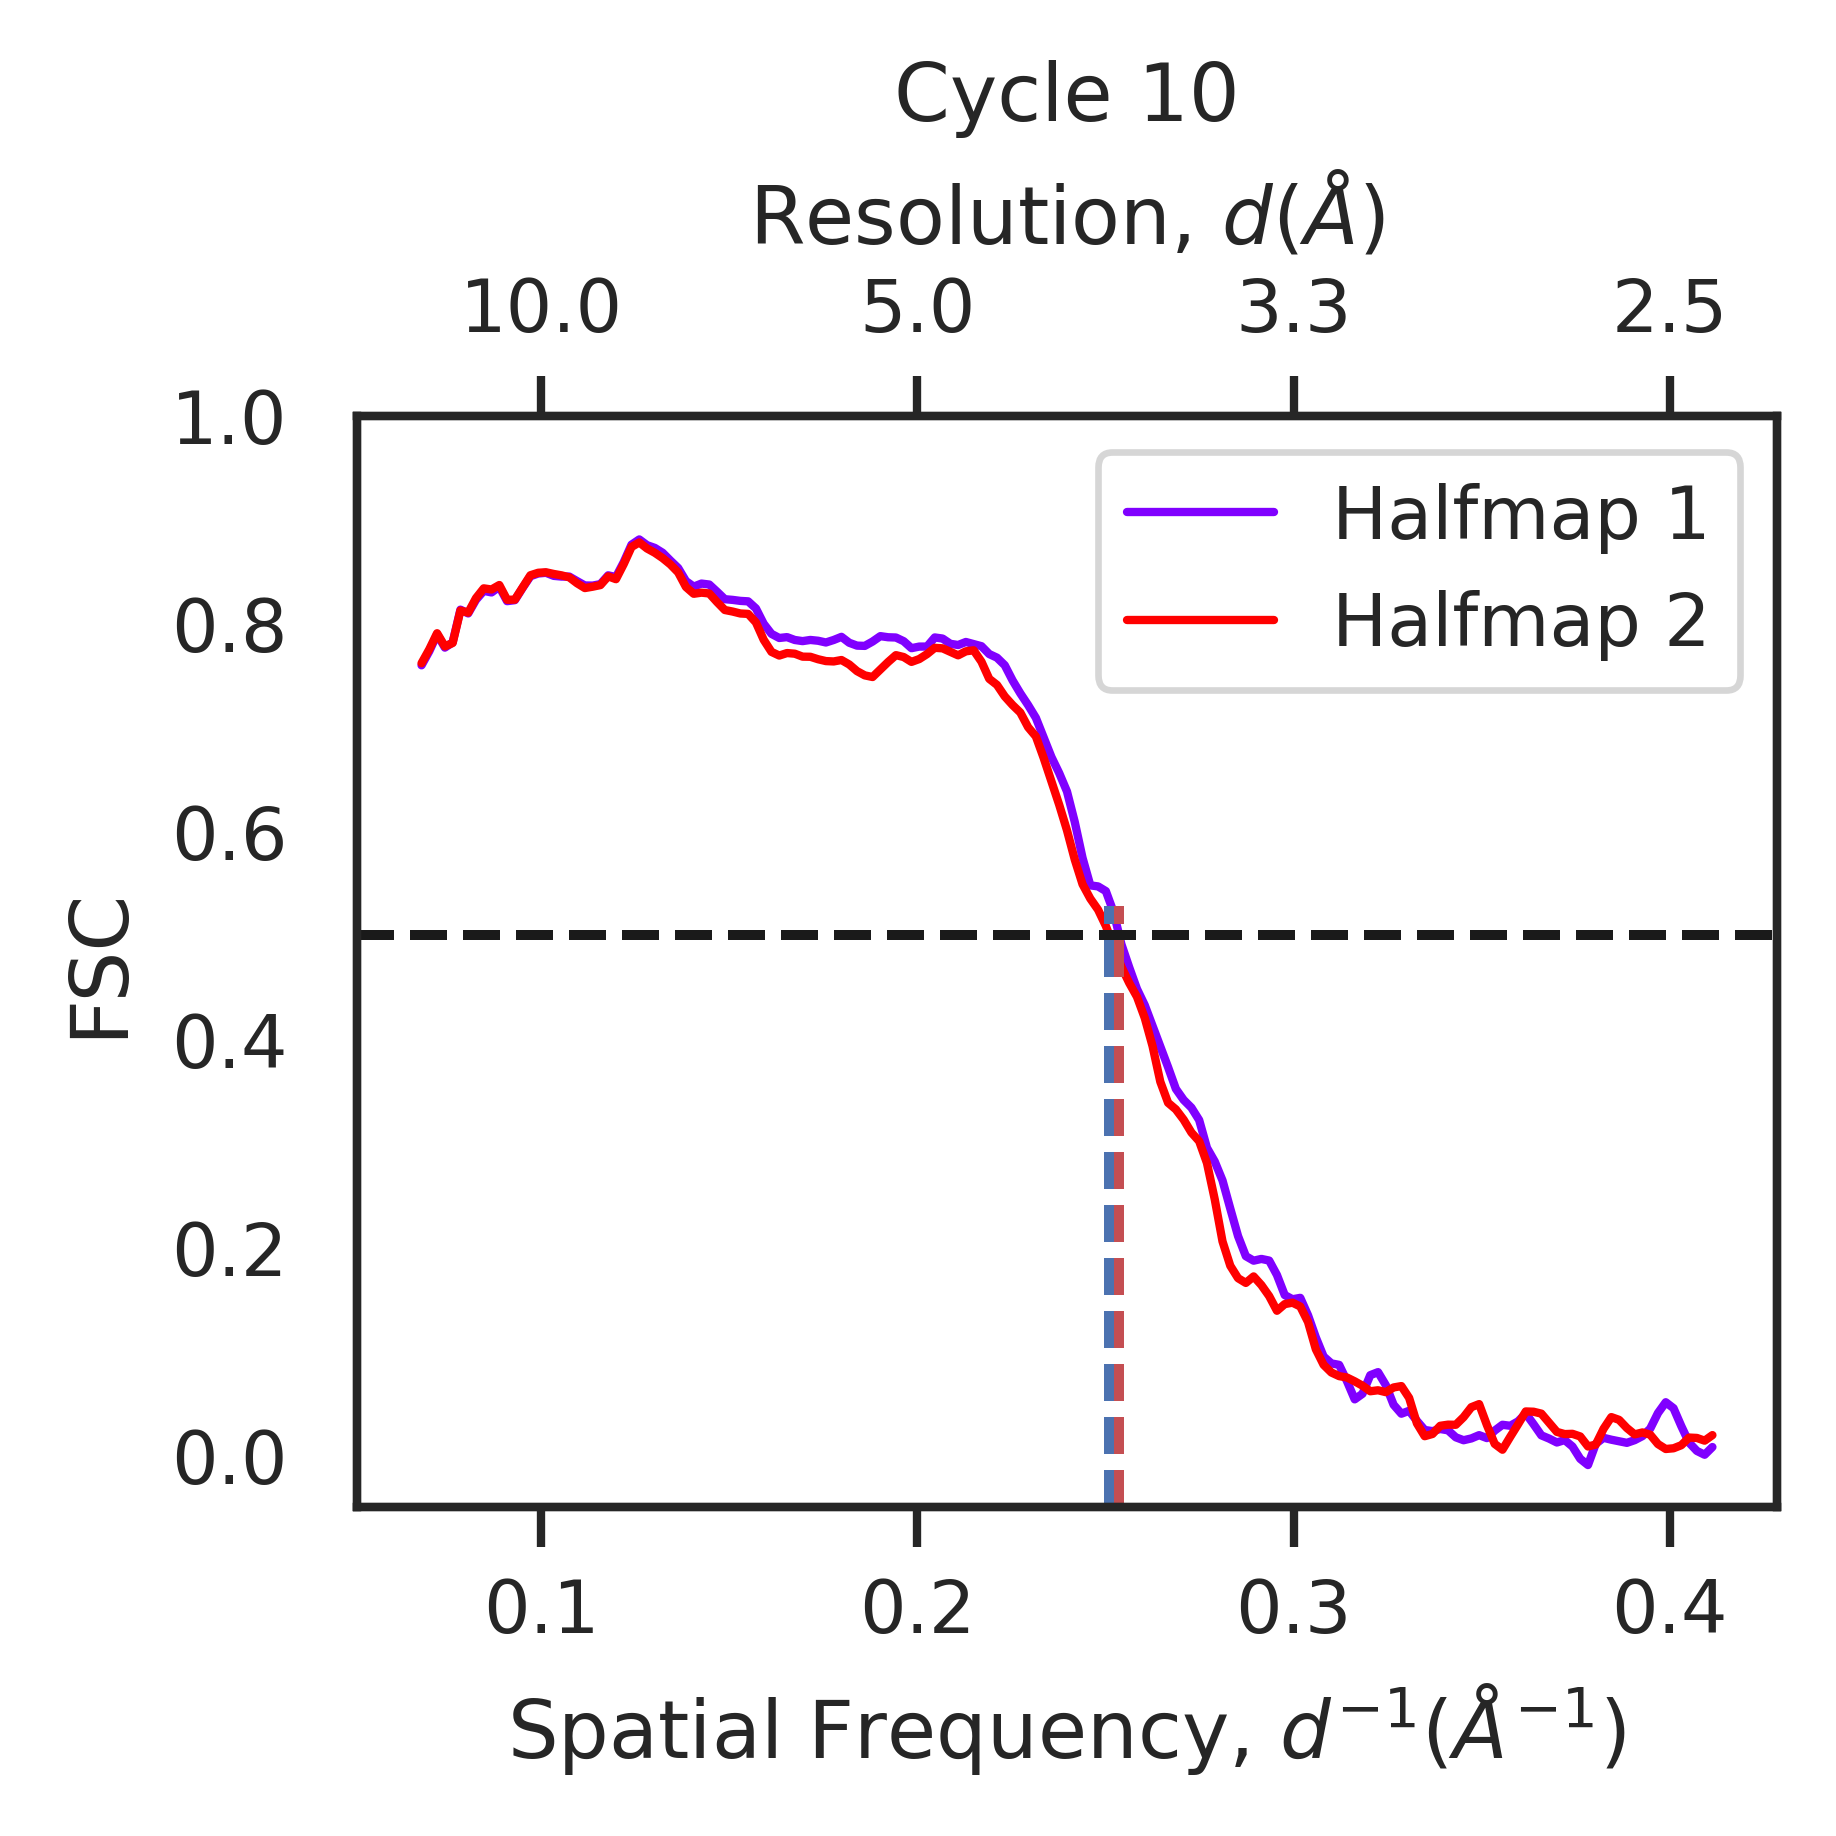

In [40]:
fig_cycle_10 = pretty_plot_fsc_curve(freq, list_of_cycle_10_fsc, legends=["Halfmap 1", "Halfmap 2"], \
                                    showPoints=False, showlegend=True, title="Cycle 10", figsize_cm=(8,8), crop_freq=(15,1.8), ylims=ylims)

freq_1, freq_2 = find_freq_value_where_fsc_drops_below_threshold(freq, *list_of_cycle_10_fsc, threshold=0.5)
freq_max = max(freq_1, freq_2)
fig_cycle_10.axes[0].axhline(y=0.5, color='k', linestyle='--')
fig_cycle_10.axes[0].axvline(x=freq_1, color='r', linestyle='--', ymax=0.55)
fig_cycle_10.axes[0].axvline(x=freq_2, color='b', linestyle='--', ymax=0.55)

fig_cycle_10.axes[0].set_ylim(ylims)

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


(-0.05, 1.0)

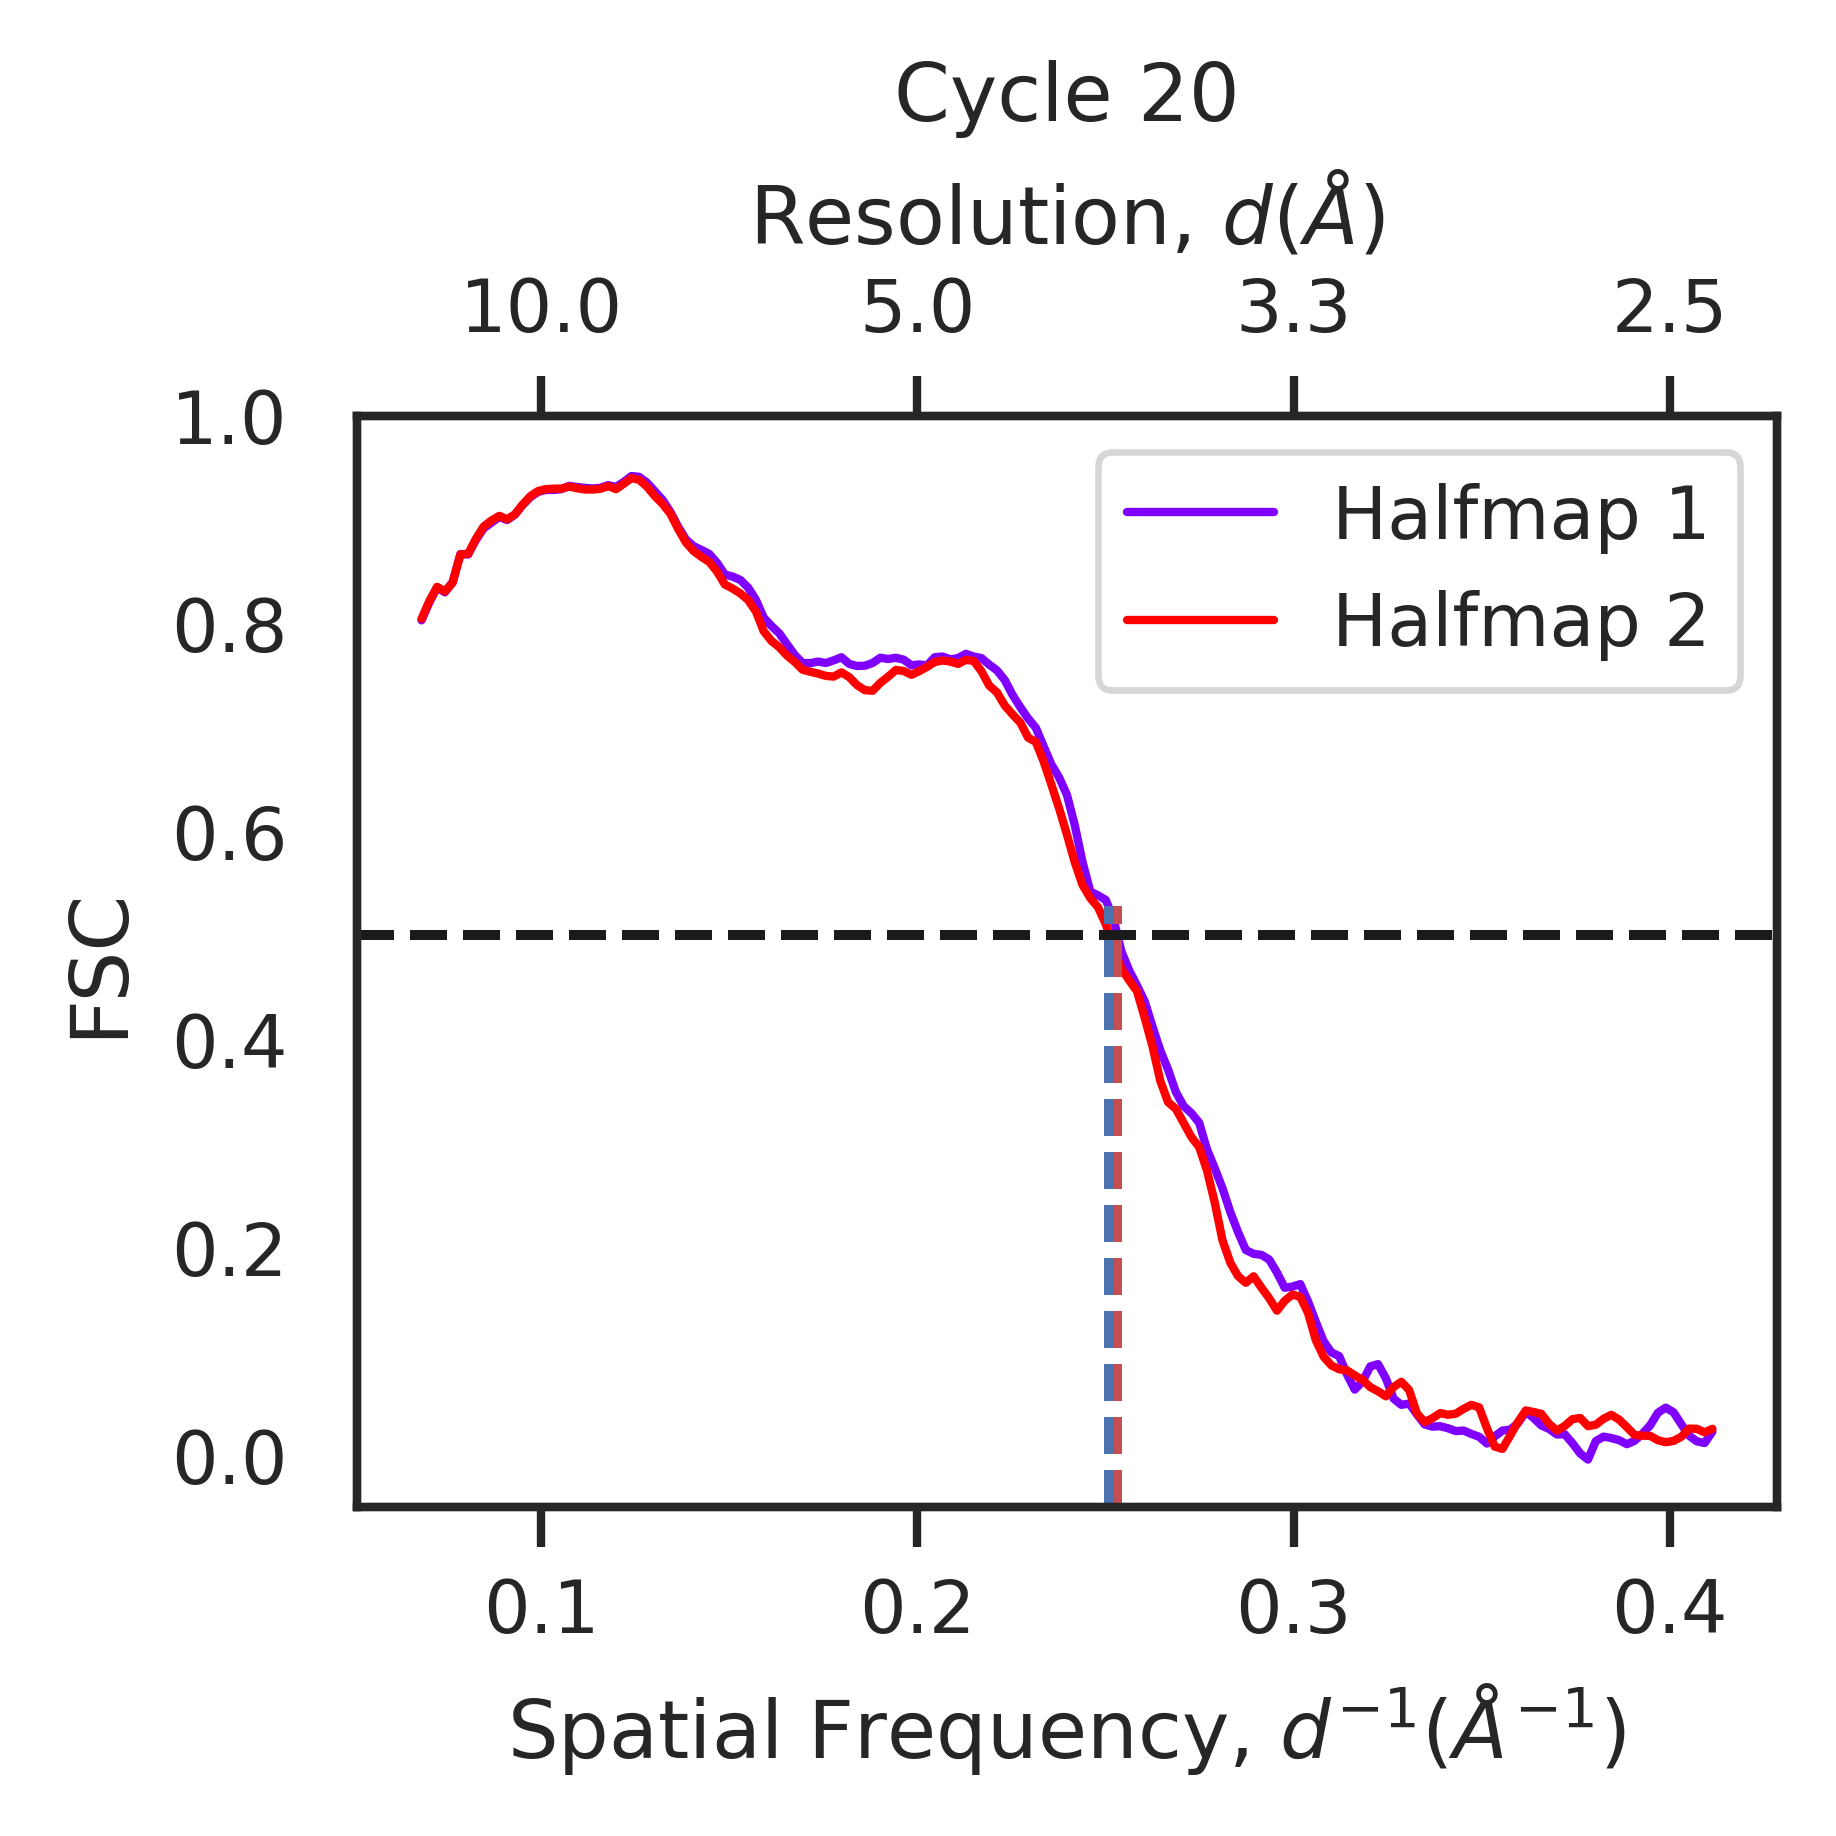

In [41]:
fig_cycle_20 = pretty_plot_fsc_curve(freq, list_of_cycle_20_fsc, legends=["Halfmap 1", "Halfmap 2"], \
                                    showPoints=False, showlegend=True, title="Cycle 20", figsize_cm=(8,8), crop_freq=(15,1.8), ylims=ylims)

freq_1, freq_2 = find_freq_value_where_fsc_drops_below_threshold(freq, *list_of_cycle_20_fsc, threshold=0.5)
freq_max = max(freq_1, freq_2)
fig_cycle_20.axes[0].axhline(y=0.5, color='k', linestyle='--')
fig_cycle_20.axes[0].axvline(x=freq_1, color='r', linestyle='--', ymax=0.55)
fig_cycle_20.axes[0].axvline(x=freq_2, color='b', linestyle='--', ymax=0.55)

fig_cycle_20.axes[0].set_ylim(ylims)

In [8]:
output_plot_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs"
fig_cycle_1.savefig(os.path.join(output_plot_folder, "figure_2_fsc_curve_cycle_1.eps"), bbox_inches="tight")
fig_cycle_5.savefig(os.path.join(output_plot_folder, "figure_2_fsc_curve_cycle_5.eps"), bbox_inches="tight")
fig_cycle_10.savefig(os.path.join(output_plot_folder, "figure_2_fsc_curve_cycle_10.eps"), bbox_inches="tight")
fig_cycle_20.savefig(os.path.join(output_plot_folder, "figure_2_fsc_curve_cycle_20.eps"), bbox_inches="tight")


NameError: name 'fig_cycle_1' is not defined

In [ ]:
## FIgure 2 compute the FSC curve for the 10th cycle with atomic and FDR mask 
from locscale.include.emmer.ndimage.filter import get_cosine_mask
from locscale.include.emmer.ndimage.map_tools import get_atomic_model_mask
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map
from locscale.include.emmer.ndimage.profile_tools import frequency_array
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

unsharpened_map_path = os.path.join(parent_folder, "emd_8702_unsharpened_map.mrc")
fdr_mask_path = os.path.join(parent_folder, "emd_8702_FDR_confidence_final.map")

refined_atomic_model_PDB_path = os.path.join(parent_folder, "PDB_5vkq_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")
refined_pseudomodel_path = os.path.join(parent_folder, "emd_8702_FDR_confidence_final_gradient_pseudomodel_proper_element_composition.pdb")
refined_hybrid_model_path = refined_model_per_iteration[10]


fdr_mask, apix = load_map(fdr_mask_path)
unsharpened_map, apix = load_map(unsharpened_map_path)

#fdr_mask_filtered = uniform_filter(fdr_mask, size=3)
fdr_mask_binarised = (fdr_mask > 0.99).astype(np.int_)
fdr_mask_softmask = get_cosine_mask(fdr_mask_binarised, 5)
model_mask_softmask = get_atomic_model_mask(emmap_path=unsharpened_map_path, pdb_path=refined_atomic_model_PDB_path, save_files=False)

refined_atomic_model_map = pdb2map(refined_atomic_model_PDB_path, apix=apix, size=unsharpened_map.shape)
refined_pseudomodel_map = pdb2map(refined_pseudomodel_path, apix=apix, size=unsharpened_map.shape)
refined_hybrid_model_map = pdb2map(refined_hybrid_model_path, apix=apix, size=unsharpened_map.shape)
#refined_hybrid_model_map_path = "/home/abharadwaj1/dev/map_sharpening/emmernet/locscale_inputs/hybrid_version_C/locscale_hybrid_version_C_model_maps/emd_8702_hybrid_model_map_refined.mrc"
#refined_hybrid_model_map, apix = load_map(refined_hybrid_model_map_path)
print(f"Done simulating all the maps")
fdr_masked_unsharpened_map = unsharpened_map# * fdr_mask_softmask
model_masked_unsharpened_map = unsharpened_map * model_mask_softmask

fdr_masked_atomic_model_map = refined_atomic_model_map# * fdr_mask_softmask
model_masked_atomic_model_map = refined_atomic_model_map * model_mask_softmask

fdr_masked_pseudomodel_map = refined_pseudomodel_map# * fdr_mask_softmask
model_masked_pseudomodel_map = refined_pseudomodel_map * model_mask_softmask

fdr_masked_hybrid_model_map = refined_hybrid_model_map# * fdr_mask_softmask
model_masked_hybrid_model_map = refined_hybrid_model_map * model_mask_softmask

fsc_curve_refined_atomic_model_fdr_mask = calculate_fsc_maps(fdr_masked_unsharpened_map, fdr_masked_atomic_model_map)
fsc_curve_refined_pseudo_model_fdr_mask = calculate_fsc_maps(fdr_masked_unsharpened_map, fdr_masked_pseudomodel_map)
fsc_curve_refined_hybrid_model_fdr_mask = calculate_fsc_maps(fdr_masked_unsharpened_map, fdr_masked_hybrid_model_map)

fsc_curve_refined_atomic_model_model_mask = calculate_fsc_maps(model_masked_unsharpened_map, model_masked_atomic_model_map)
fsc_curve_refined_pseudo_model_model_mask = calculate_fsc_maps(model_masked_unsharpened_map, model_masked_pseudomodel_map)
fsc_curve_refined_hybrid_model_model_mask = calculate_fsc_maps(model_masked_unsharpened_map, model_masked_hybrid_model_map)

freq = frequency_array(fsc_curve_refined_atomic_model_fdr_mask, apix)

In [ ]:
wilson_cutoff = 1/10 
index_wilson_cutoff = np.where(freq > wilson_cutoff)[0][0]
# sum of lower freq until wilson cutoff
fsc_curve_refined_atomic_model_fdr_mask_guinier = np.sum(fsc_curve_refined_atomic_model_fdr_mask[:index_wilson_cutoff])
fsc_curve_refined_pseudo_model_fdr_mask_guinier = np.sum(fsc_curve_refined_pseudo_model_fdr_mask[:index_wilson_cutoff])
fsc_curve_refined_hybrid_model_fdr_mask_guinier = np.sum(fsc_curve_refined_hybrid_model_fdr_mask[:index_wilson_cutoff])
# sum of higher freq from wilson cutoff to nyquist
fsc_curve_refined_atomic_model_fdr_mask_wilson = np.sum(fsc_curve_refined_atomic_model_fdr_mask[index_wilson_cutoff:])
fsc_curve_refined_pseudo_model_fdr_mask_wilson = np.sum(fsc_curve_refined_pseudo_model_fdr_mask[index_wilson_cutoff:])
fsc_curve_refined_hybrid_model_fdr_mask_wilson = np.sum(fsc_curve_refined_hybrid_model_fdr_mask[index_wilson_cutoff:])

print("Guiniar region")
print("Atomic model: ", fsc_curve_refined_atomic_model_fdr_mask_guinier)
print("Pseudomodel: ", fsc_curve_refined_pseudo_model_fdr_mask_guinier)
print("Hybrid model: ", fsc_curve_refined_hybrid_model_fdr_mask_guinier)
print("Wilson region")
print("Atomic model: ", fsc_curve_refined_atomic_model_fdr_mask_wilson)
print("Pseudomodel: ", fsc_curve_refined_pseudo_model_fdr_mask_wilson)
print("Hybrid model: ", fsc_curve_refined_hybrid_model_fdr_mask_wilson)





In [ ]:
f = calculate_fsc_maps(unsharpened_map_path, refined_atomic_model_map)
plt.plot(f)


In [ ]:
fig, ax = plt.subplots(1,4,figsize=(15,8))
ax[0].imshow(refined_atomic_model_map[:,:,200])
ax[1].imshow(fdr_mask_softmask[:,:,200])
ax[2].imshow(refined_hybrid_model_map[:,:,200])
ax[3].imshow(unsharpened_map[:,:,200])

In [ ]:
save_as_mrc(refined_atomic_model_map, "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/emd_8702_atomic_model_map_refined.mrc", apix=apix)

In [ ]:
plt.plot(fsc_curve_refined_hybrid_model_fdr_mask)

In [ ]:
list_of_fdr_masked_fsc_curves = [fsc_curve_refined_atomic_model_fdr_mask, fsc_curve_refined_pseudo_model_fdr_mask, fsc_curve_refined_hybrid_model_fdr_mask]
list_of_model_masked_fsc_curves = [fsc_curve_refined_atomic_model_model_mask, fsc_curve_refined_pseudo_model_model_mask, fsc_curve_refined_hybrid_model_model_mask]

fig_fdr_masked = pretty_plot_fsc_curve(freq, list_of_fdr_masked_fsc_curves, legends=["Refined atomic model", "Refined pseudomodel", "Refined hybrid model"], \
                                    title="FSC curves for FDR masked maps", figsize_cm=(8,8), fontsize=8, showlegend=True, crop_freq=(50,1.8))

In [ ]:
fig_model_masked = pretty_plot_fsc_curve(freq, list_of_model_masked_fsc_curves, legends=["Refined atomic model", "Refined pseudomodel", "Refined hybrid model"], \
                                    title="FSC curves for model masked maps", figsize_cm=(8,8), fontsize=8, showlegend=True)

In [ ]:
import json 
data_output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/emd_8702"
# choose a suitable name to dump the data
if not os.path.exists(data_output_dir):
    os.makedirs(data_output_dir)
    
fsc_curves_fdr_mask_atomic_mask = {
    "freq": freq.tolist(),
    "fsc_curve_refined_atomic_model_fdr_mask": fsc_curve_refined_atomic_model_fdr_mask.tolist(),
    "fsc_curve_refined_pseudo_model_fdr_mask": fsc_curve_refined_pseudo_model_fdr_mask.tolist(),
    "fsc_curve_refined_hybrid_model_fdr_mask": fsc_curve_refined_hybrid_model_fdr_mask.tolist(),
    "fsc_curve_refined_atomic_model_model_mask": fsc_curve_refined_atomic_model_model_mask.tolist(),
    "fsc_curve_refined_pseudo_model_model_mask": fsc_curve_refined_pseudo_model_model_mask.tolist(),
    "fsc_curve_refined_hybrid_model_model_mask": fsc_curve_refined_hybrid_model_model_mask.tolist(),
}

with open(os.path.join(data_output_dir, "fsc_curves_fdr_mask_atomic_mask.json"), "w") as f:
    json.dump(fsc_curves_fdr_mask_atomic_mask, f, indent=4)

In [ ]:
# import json
# import os 
# data_output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/emd_8702"
# fsc_curves_fdr_mask_atomic_mask  = json.load(open(os.path.join(data_output_dir, "fsc_curves_fdr_mask_atomic_mask.json"), "r"))

# list_of_fdr_masked_fsc_curves = [
#     fsc_curves_fdr_mask_atomic_mask['fsc_curve_refined_atomic_model_fdr_mask'],
#     fsc_curves_fdr_mask_atomic_mask['fsc_curve_refined_pseudo_model_fdr_mask'],
#     fsc_curves_fdr_mask_atomic_mask['fsc_curve_refined_hybrid_model_fdr_mask']
# ]

# list_of_model_masked_fsc_curves = [
#     fsc_curves_fdr_mask_atomic_mask['fsc_curve_refined_atomic_model_model_mask'],
#     fsc_curves_fdr_mask_atomic_mask['fsc_curve_refined_pseudo_model_model_mask'],
#     fsc_curves_fdr_mask_atomic_mask['fsc_curve_refined_hybrid_model_model_mask']
# ]



In [ ]:
fig_fdr_masked.savefig(os.path.join(data_output_dir, "figure_2_fsc_curves_fdr_masked.eps"), bbox_inches="tight")
fig_model_masked.savefig(os.path.join(data_output_dir, "figure_2_fsc_curves_model_masked.eps"), bbox_inches="tight")

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 

fsc_average_halfmap_1_pickle = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis/refmac_iteration_analysis_output_30/fsc_average_halfmap_1_cycle30_masked.pickle"
fsc_average_halfmap_2_pickle = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis/refmac_iteration_analysis_output_30/fsc_average_halfmap_2_cycle30_masked.pickle"

fsc_average_halfmap_1 = pickle.load(open(fsc_average_halfmap_1_pickle, "rb"))
fsc_average_halfmap_2 = pickle.load(open(fsc_average_halfmap_2_pickle, "rb"))

In [48]:
refined_modmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/PDB_5vkq_unrefined_shifted_servalcat_refined_shifted_servalcat_refined_shifted_bfactors..m_4locscale.mrc"
input_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations"
emmap_path = os.path.join(input_folder, "emd_8702_unsharpened_map.mrc")
atomic_mask_path = "/home/abharadwaj1/dev/data/atomic_model_mask/atomic_model_mask_8702_5vkq.mrc"

refined_atomic_modelmap_from_locscale, apix = load_map(refined_modmap_path)
unsharpened_emmap, apix = load_map(emmap_path)
softmask, apix = load_map(atomic_mask_path)

fsc_refined_atomic_model_map = calculate_fsc_maps(unsharpened_emmap * softmask, refined_atomic_modelmap_from_locscale * softmask)
fsc_average_reference = np.mean(fsc_refined_atomic_model_map)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


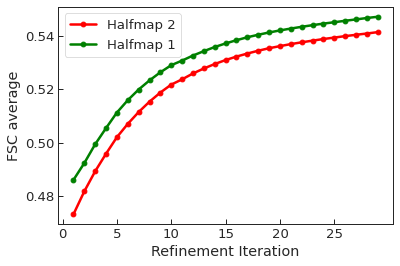

In [9]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})

xarray = list(fsc_average_halfmap_1.keys())
yarray = [fsc_average_halfmap_2[i][1] for i in fsc_average_halfmap_2.keys()]
yarray_halfmap1 = [fsc_average_halfmap_1[i][1] for i in fsc_average_halfmap_1.keys()]
plt.plot(xarray, yarray, "ro-", label="Halfmap 2")
plt.plot(xarray, yarray_halfmap1, "go-", label="Halfmap 1")
plt.xticks(list(fsc_average_halfmap_1.keys()))
plt.xlabel('Refinement Iteration')
plt.ylabel('FSC average')
plt.legend()
# show every 5 iteration number on x axis
plt.xticks(np.arange(0, 30, 5))
# draw a horizontal line at fsc_average_reference
#plt.axhline(y=fsc_average_reference, color='k', linestyle='--')
plt.savefig(os.path.join(output_plot_folder, "figure_2_fsc_average_halfmap_1_and_2_again.eps"), bbox_inches="tight")

In [31]:
def pretty_plot_rainbow_series(x_array, list_of_y_array, figsize_cm=(14, 8), fontsize=10, linewidth=1,
                       font="Helvetica", fontscale=1, alpha=0.2, xticks=None, num_xticks=5, 
                       yticks=None, ylims=None, xlims=None, labelsize=None, title=None):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    import numpy as np
    import seaborn as sns
    import matplotlib
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.rcParams.update({'font.size': fontsize})
    
    # Convert cm to inches for figsize
    figsize = (figsize_cm[0] / 2.54, figsize_cm[1] / 2.54)
    
    # DPI is fixed to 600 for publication quality
    fig, ax1 = plt.subplots(figsize=figsize, dpi=600)
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    sns.set_style("white")

    # Set the color palette
    color = cm.rainbow(np.linspace(0, 1, len(list_of_y_array)))
    
    for idx, y in enumerate(list_of_y_array):
        ax1.plot(x_array, y, color=color[idx], linewidth=linewidth)

    # Set x and y ticks if provided
    if xticks is not None:
        ax1.set_xticks([round(xtick, 2) for xtick in xticks])
    else:
        ax1.set_xticks(np.linspace(x_array[0], x_array[-1], num_xticks).round(2))
    if yticks is not None:
        ax1.set_yticks(yticks)

    # Set x and y limits if provided
    if ylims is not None:
        ax1.set_ylim(ylims)
    if xlims is not None:
        ax1.set_xlim(xlims)

    # Set label size if provided
    if labelsize is not None:
        ax1.tick_params(axis='both', which='major', labelsize=labelsize)

    # Set the axis labels
    ax1.set_xlabel(r'Spatial frequency ($\AA^{-1}$)')
    ax1.set_ylabel('FSC')

    # Add a second X axis for resolution
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(np.round(1 / ax1.get_xticks(), 1))
    ax2.set_xlabel(r'Resolution ($\AA$)')

    if title is not None:
        ax1.set_title(title)

    plt.tight_layout()

    return fig

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


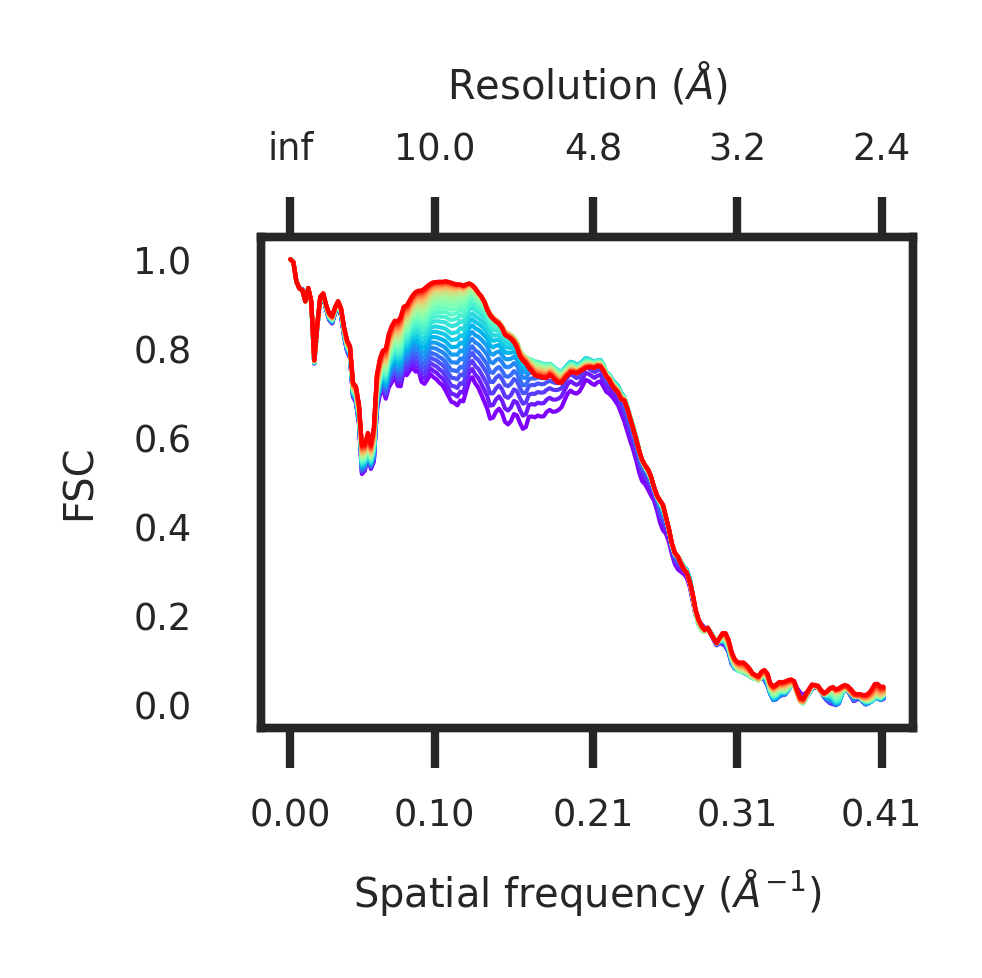

In [41]:
from locscale.include.emmer.ndimage.profile_tools import frequency_array

freq = frequency_array(fsc_average_halfmap_1[1][2], apix)
list_of_y_array = [fsc_average_halfmap_2[i][2] for i in fsc_average_halfmap_2.keys()]

fig = pretty_plot_rainbow_series(freq, list_of_y_array, figsize_cm=(4,4), fontscale=0.5,linewidth=0.5)
fig.savefig(os.path.join(output_plot_folder, "figure_2_fsc_curves_full.eps"), bbox_inches="tight")   

In [42]:
output_plot_folder

'/home/abharadwaj1/papers/elife_paper/figure_information/outputs'